In [1]:
from WingWatch.Intersections.detection import Detection
from WingWatch.Intersections import tri
import trimesh
import pandas as pd
import numpy as np
import WingWatch.Intersections.physicalTrackLimiter as PTL
from WingWatch.Equipment import station
from WingWatch.Equipment import antenna
from WingWatch.Tools import translation,spheres
from WingWatch.Tools import point_check as pc
import matplotlib.pyplot as plt
import scipy.spatial as ss

test_data_file = 'Fake_Calibration_Data.csv'
df = pd.read_csv(test_data_file)


Station_1 = station.Station('Station_1',41.1479, -71.5901)
Station_1_Comp_Data = pd.read_csv(test_data_file)
Station_2_pos = translation.convert_back_to_lla([0,-200,0],Station_1.lat,Station_1.long,Station_1.alt)
Station_3_pos = translation.convert_back_to_lla([100*np.sqrt(3),-100,0],Station_1.lat,Station_1.long,Station_1.alt)


freq_of_antenna_MHz = 434
antenna_number = '1'
antenna_type = 'test'
bearing_of_antenna = 0 


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_1_Comp_Data)
Station_1.add_antenna(a1)

Station_2 = station.Station('Station_2',Station_2_pos[0], Station_2_pos[1])
Station_2_Comp_Data = pd.read_csv(test_data_file)


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_2_Comp_Data)
Station_2.add_antenna(a1)




Station_3 = station.Station('Station_3',Station_3_pos[0], Station_3_pos[1])
Station_3_Comp_Data = pd.read_csv(test_data_file)

a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_3_Comp_Data)
Station_3.add_antenna(a1)


df_detections = pd.read_csv('straight_walk_Detections.csv')
df_walk = pd.read_csv('straight_walk.csv')


#first step, generate all of the single point detections
g = 0 
points_to_follow = []
cx_cent = []
cy_cent = []
for i in range(len(df_detections['Station 1'])):
    det1 = Detection(Station_1,df_detections['Station 1'][i],1)
    det2 = Detection(Station_2,df_detections['Station 2'][i],1)
    det3 = Detection(Station_3,df_detections['Station 3'][i],1)
    data_to_send_through = [det1,det2,det3]
    intersections,hull_of_intersections = tri.overlap_of_three_radiation_patterns(data_to_send_through)
    points_to_follow.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cz = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,2])
    cx_cent.append(cx)
    cy_cent.append(cy)
    g += pc.point_in_hull(np.array([df_walk.iloc[i].X,df_walk.iloc[i].Y,df_walk.iloc[i].Z]),hull_of_intersections,tolerance=2.5)


1 added to Station_1's antennas.
1 added to Station_2's antennas.
1 added to Station_3's antennas.


In [32]:
from sklearn.neighbors import KNeighborsRegressor


#training_data
Station_1_pos = [0,0,0]
Station_2_pos = translation.XYZ_distance(Station_1.lat,Station_1.long,Station_1.alt,Station_2.lat,Station_2.long,Station_2.alt)
Station_3_pos = translation.XYZ_distance(Station_1.lat,Station_1.long,Station_1.alt,Station_3.lat,Station_3.long,Station_3.alt)

def get_rssi_at_pos(Station,Ant_Num,Offset,query_point):
    data_1 = Station.antennas[Ant_Num-1].rad_pattern
    
    data_1['X'] = data_1['X'] + Offset[0]
    
    data_1['Y'] = data_1['Y'] + Offset[1]
    
    data_1['Z'] = data_1['Z'] + Offset[2]
    
    data_1 = data_1.to_numpy()
    
    
    coordinates = data_1[:, :3]  # First three columns are X, Y, Z
    rssi_values = data_1[:, 3]   # Fourth column is RSSI
    
    k = 3  # Choose the number of neighbors
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')  # Weighted by inverse distance
    knn.fit(coordinates, rssi_values)
    
    predicted_rssi = knn.predict(query_point)

    return predicted_rssi



get_rssi_at_pos(Station_1,1,np.array([0,0,0]),np.array([[3.5, 4.5, 5.5]]))
get_rssi_at_pos(Station_2,1,np.array(Station_2_pos),np.array([[3.5, 4.5, 5.5]]))
get_rssi_at_pos(Station_3,1,np.array(Station_3_pos),np.array([[3.5, 4.5, 5.5]]))



array([68.])

In [ ]:
learning_rate = 10
iterations = 20


antennas = [np.array(Station_1_pos),np.array(Station_2_pos),np.array(Station_3_pos)]


def gradient_descent(antennas, actual_rssi, initial_position, learning_rate, iterations):
    position = initial_position
    for j in range(iterations):
        # Calculate predicted RSSI at the current position
        print(j)
        
        rssi_1 = get_rssi_at_pos(Station_1,1,np.array([0,0,0]),np.array([position]))
        rssi_2 = get_rssi_at_pos(Station_2,1,np.array(Station_2_pos),np.array([position]))
        rssi_3 = get_rssi_at_pos(Station_3,1,np.array(Station_3_pos),np.array([position]))
        
        predicted_rssi = np.array([rssi_1,rssi_2,rssi_3])
        
        # Compute the error (cost) between actual and predicted RSSI
        error = predicted_rssi - actual_rssi
        
        # Gradient calculation (derivative of cost function with respect to position)
        gradient = np.zeros(3)
        for i in range(len(antennas)):
            # Derivative of RSSI w.r.t. position (x, y, z)
            distance = np.linalg.norm(antennas[i] - position)
            direction = (position - antennas[i]) / (distance + 1e-6)
            gradient += 2 * error[i] * direction / (distance + 1e-6)
        
        # Update the position of the test point
        position -= learning_rate * gradient
        
    return position


optimized_position = gradient_descent(antennas, np.array([det1.rssi,det2.rssi,det3.rssi]), [cx,cy,cz], learning_rate, iterations)




0
1
2
3
4
5
6
7
8
9
10


In [46]:
optimized_position

array([102.60728878, -99.76161168,   0.41175213])

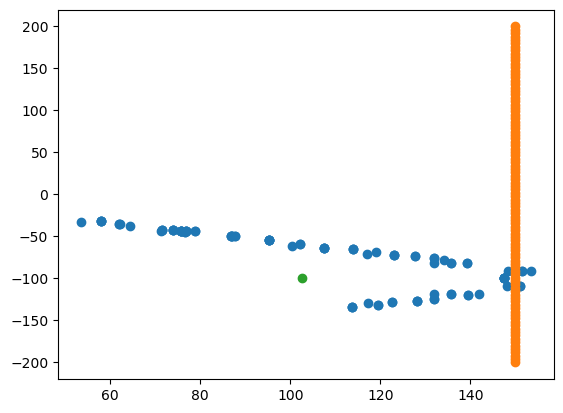

In [49]:
plt.scatter(cx_cent,cy_cent)
plt.scatter(df_walk.X,df_walk.Y)
plt.scatter(optimized_position[0],optimized_position[1])

In [9]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 79.4 MB/s eta 0:00:0031m95.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 68.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
